In [1]:
import pandas as pd
import sys
sys.path.append('../')
from utils.copernicus import CopernicusDEM
import requests

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', False)

In [27]:
df_path = 'D:\\Simon\\Documents\\GP\\data\\datasets\\selected_bird_species_with_grids_50km.csv'
df = pd.read_csv(df_path, index_col=0)

C:\Users\simon\AppData\Local\Temp\ipykernel_12416\1772750792.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_path, index_col=0)


In [28]:
df.head(2)

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country,eea_grid_id
0,29666972,8.0,Haubentaucher,2018-01-01,NaN,53.157760,8.676993,place,-1.051010,0.0,0,37718.0,de,50kmE4200N3300
1,29654244,397.0,Schwarzkehlchen,2018-01-01,NaN,53.127639,8.957263,square,0.760781,2.0,0,37803.0,de,50kmE4250N3300


### Add elevation features

In [29]:
copernicus = CopernicusDEM(raster_paths=['D:\\Simon\\Documents\\GP\\data\\util_files\\EU_DEM\\eu_dem_v11_E40N20.TIF', 'D:\\Simon\\Documents\\GP\\data\\util_files\\EU_DEM\\eu_dem_v11_E40N30.TIF'])

In [30]:
df = copernicus.get_elevation(df, lat_col='coord_lat', lon_col='coord_lon')

In [31]:
df.head(4)

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country,eea_grid_id,elevation
0,29666972,8.0,Haubentaucher,2018-01-01,NaN,53.157760,8.676993,place,-1.051010,0.0,0,37718.0,de,50kmE4200N3300,-1.051010
1,29654244,397.0,Schwarzkehlchen,2018-01-01,NaN,53.127639,8.957263,square,0.760781,2.0,0,37803.0,de,50kmE4250N3300,0.760781
2,29654521,463.0,Wiesenpieper,2018-01-01,NaN,50.850941,12.146953,place,270.831300,2.0,0,39627.0,de,50kmE4450N3050,270.831299
3,29666414,8.0,Haubentaucher,2018-01-01,NaN,51.076006,11.038316,place,158.941010,8.0,0,38301.0,de,50kmE4350N3100,158.941010


In [32]:
df['altitude'] = df['elevation']
df.drop(columns=['elevation'], inplace=True)

### Check for high negative altitude values

In [33]:
print(df.altitude.value_counts())

altitude
-3.402823e+38    51606
 3.913700e+02    33840
 4.265330e+02    28527
 3.182081e+02    12550
 3.718830e+02    9445 
                 ...  
 8.830636e+02    1    
 9.352755e+02    1    
 7.191224e+02    1    
 9.459383e+02    1    
 8.021597e+02    1    
Name: count, Length: 910675, dtype: int64


In [34]:
min_altitude = df.altitude.min()
df_min_altitude = df[df.altitude == min_altitude]

In [35]:
df_min_altitude.head(5)

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country,eea_grid_id
56,29660454,8.0,Haubentaucher,2018-01-01,NaN,53.780461,7.947729,precise,-3.402823e+38,1.0,0,77774.0,de,50kmE4150N3400
131,29652796,158.0,Seeadler,2018-01-01,NaN,53.702563,7.740776,square,-3.402823e+38,1.0,0,43003.0,de,50kmE4150N3400
278,29667163,8.0,Haubentaucher,2018-01-01,NaN,54.505650,9.553208,precise,-3.402823e+38,2.0,0,37768.0,de,50kmE4250N3450
301,29655667,8.0,Haubentaucher,2018-01-01,02:44,54.758682,8.295368,precise,-3.402823e+38,1.0,0,42717.0,de,50kmE4200N3500
302,29653528,8.0,Haubentaucher,2018-01-01,03:14,54.758271,8.294853,precise,-3.402823e+38,2.0,0,45902.0,de,50kmE4200N3500


### Set 3.402823e+38 altitude to 0

In [36]:
df.loc[df.altitude==df.altitude.min()] = 0 

In [37]:
print(df.altitude.value_counts())

altitude
0.000000      56511
391.369995    33840
426.532990    28527
318.208130    12550
371.882996    9445 
              ...  
883.063599    1    
935.275513    1    
719.122437    1    
945.938293    1    
802.159729    1    
Name: count, Length: 910674, dtype: int64


### Experiment with elevation APIs

In [38]:
def get_elevation(lat, long):
    query = f'https://api.open-elevation.com/api/v1/lookup?locations={lat},{long}'
    r = requests.get(query).json()
    print(r)
    elevation = r['results'][0]['elevation']
    return elevation

In [39]:
def get_elevation2(lat, long):
    query = f'https://api.opentopodata.org/v1/eudem25m?locations={lat},{long}'
    r = requests.get(query).json()
    elevation = r['results'][0]['elevation']
    return elevation

In [40]:
df_min_altitude['altitude'] = df_min_altitude.head(10).apply(lambda row: get_elevation(row['coord_lat'], row['coord_lon']), axis=1)

{'results': [{'latitude': 53.780461, 'longitude': 7.947729, 'elevation': 0.0}]}
{'results': [{'latitude': 53.702563, 'longitude': 7.740776, 'elevation': 0.0}]}
{'results': [{'latitude': 54.50565, 'longitude': 9.553208, 'elevation': 0.0}]}
{'results': [{'latitude': 54.758682, 'longitude': 8.295368, 'elevation': 4.0}]}
{'results': [{'latitude': 54.758271, 'longitude': 8.294853, 'elevation': 1.0}]}
{'results': [{'latitude': 54.34975, 'longitude': 10.624524, 'elevation': -3.0}]}
{'results': [{'latitude': 54.34975, 'longitude': 10.624524, 'elevation': -3.0}]}
{'results': [{'latitude': 54.34975, 'longitude': 10.624524, 'elevation': -3.0}]}
{'results': [{'latitude': 54.266281, 'longitude': 13.313914, 'elevation': 0.0}]}
{'results': [{'latitude': 54.34531, 'longitude': 13.581008, 'elevation': 0.0}]}


C:\Users\simon\AppData\Local\Temp\ipykernel_12416\2604693980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min_altitude['altitude'] = df_min_altitude.head(10).apply(lambda row: get_elevation(row['coord_lat'], row['coord_lon']), axis=1)


In [41]:
df_min_altitude.head(5)

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country,eea_grid_id
56,29660454,8.0,Haubentaucher,2018-01-01,NaN,53.780461,7.947729,precise,0.0,1.0,0,77774.0,de,50kmE4150N3400
131,29652796,158.0,Seeadler,2018-01-01,NaN,53.702563,7.740776,square,0.0,1.0,0,43003.0,de,50kmE4150N3400
278,29667163,8.0,Haubentaucher,2018-01-01,NaN,54.505650,9.553208,precise,0.0,2.0,0,37768.0,de,50kmE4250N3450
301,29655667,8.0,Haubentaucher,2018-01-01,02:44,54.758682,8.295368,precise,4.0,1.0,0,42717.0,de,50kmE4200N3500
302,29653528,8.0,Haubentaucher,2018-01-01,03:14,54.758271,8.294853,precise,1.0,2.0,0,45902.0,de,50kmE4200N3500


### PCA with elevation features

Text(7, 0.75, 'strong correlation')

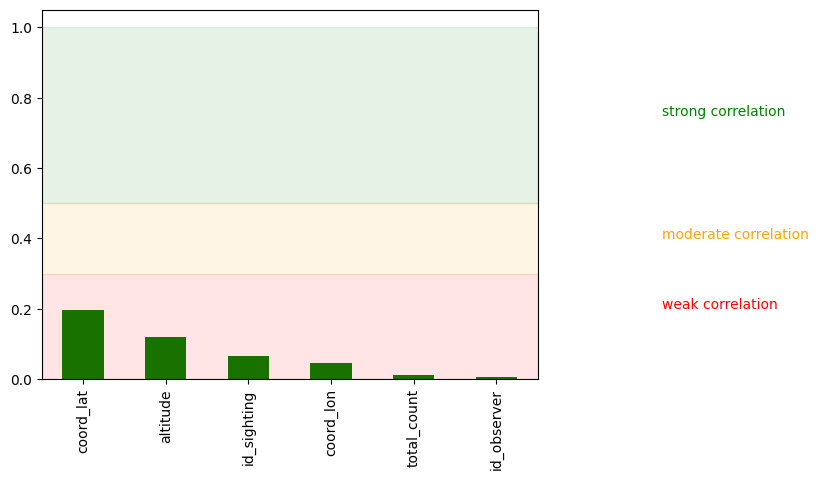

In [42]:
import matplotlib.pyplot as plt
df_for_pca = df.drop(columns=['name_species', 'date', 'timing', 'precision', 'atlas_code', 'country', 'eea_grid_id'])
df_corr = df_for_pca.corr()['id_species'].abs().sort_values(ascending=False)
df_corr.drop('id_species', inplace=True)
ax = df_corr.plot.bar(color='green')

ax.axhspan(0, 0.3, alpha=0.1, color='red')
ax.axhspan(0.3, 0.5, alpha=0.1, color='orange')
ax.axhspan(0.5, 1, alpha=0.1, color='green')
ax.text(7,0.2, s='weak correlation', color='red')
ax.text(7,0.4, s='moderate correlation', color='orange')
ax.text(7,0.75, s='strong correlation', color='green')

In [ ]:
df.to_csv(df_path)